# **Build Recommend System**

## *Install & Import libraries*

In [1]:
# Import libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import requests
import json
import tensorflow as tf
import keras
from pprint import pprint

2023-12-23 23:25:33.191183: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-23 23:25:33.215399: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-23 23:25:33.215418: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-23 23:25:33.216077: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-23 23:25:33.221112: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Use TensorFlow on the GPU
tf.config.list_physical_devices("GPU")


Num GPUs Available:  1


2023-12-23 23:25:34.016110: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

2023-12-23 23:25:34.040418: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:25:34.040453: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## *Loading data by API*

### *Review data*

In [3]:
import pandas as pd

raw_review_data = pd.read_csv("reviews.csv").to_dict("records")

In [4]:
def parser_infor_review(json):
  d = dict()
  d['user_id'] = json.get('user_id_review')
  d['movie_id'] = json.get('movie_id')
  d['rating'] = json.get('ratings')
  d['agree'] = json.get('total_agree')

  return d

In [5]:
review_data = []
for infor in raw_review_data:
    review_data.append(parser_infor_review(infor))

In [6]:
df = pd.DataFrame(review_data)
df = df[~df['rating'].isna()]

In [7]:
df['rating'] = df['rating'].apply(pd.to_numeric, errors='coerce')
df

,user_id,movie_id,rating,agree
1,ur2467618,tt0004972,3.0,98 out of 159
2,ur1888886,tt0004972,10.0,192 out of 321
3,ur15148330,tt0004972,8.0,38 out of 60
7,ur2670273,tt0004972,1.0,216 out of 401
8,ur16588387,tt0004972,1.0,173 out of 300
...,...,...,...,...
3396663,ur151545409,tt9907782,6.0,0 out of 2
3396664,ur158343794,tt9907782,5.0,0 out of 3
3396665,ur112699390,tt9907782,4.0,1 out of 8
3396666,ur90893269,tt9907782,6.0,0 out of 2


In [8]:
df = df[df['rating'] != {'$numberDouble': 'NaN'}]
df

,user_id,movie_id,rating,agree
1,ur2467618,tt0004972,3.0,98 out of 159
2,ur1888886,tt0004972,10.0,192 out of 321
3,ur15148330,tt0004972,8.0,38 out of 60
7,ur2670273,tt0004972,1.0,216 out of 401
8,ur16588387,tt0004972,1.0,173 out of 300
...,...,...,...,...
3396663,ur151545409,tt9907782,6.0,0 out of 2
3396664,ur158343794,tt9907782,5.0,0 out of 3
3396665,ur112699390,tt9907782,4.0,1 out of 8
3396666,ur90893269,tt9907782,6.0,0 out of 2


### *Movie data*

In [9]:
raw_movie_data = pd.read_csv("movies.csv").to_dict("records")

In [10]:
def parser_infor_movie(json):
  d = dict()
  d['movie_id'] = json.get('id')
  d['movie_title'] = json.get('title')

  return d

In [11]:
movie_data = []
for infor in raw_movie_data:
    movie_data.append(parser_infor_movie(infor))

In [12]:
df_2 = pd.DataFrame(movie_data)
df_2

,movie_id,movie_title
0,tt0000012,L&apos;arrivée d&apos;un train à La Ciotat
1,tt0000417,Le voyage dans la lune
2,tt0000439,The Great Train Robbery
3,tt0000546,Dream of a Rarebit Fiend
4,tt0000628,Adventures of Dollie
...,...,...
32149,tt9906260,Hero
32150,tt9907782,Eight for Silver
32151,tt9908860,Blown Away
32152,tt9914644,9/11: Escape from the Towers


## *Forming suitable dataset for Deep Learning model*

In [13]:
merged_dataset = pd.merge(df, df_2, how='inner', on='movie_id')
merged_dataset.head()

,user_id,movie_id,rating,agree,movie_title
0,ur2467618,tt0004972,3.0,98 out of 159,The Birth of a Nation
1,ur1888886,tt0004972,10.0,192 out of 321,The Birth of a Nation
2,ur15148330,tt0004972,8.0,38 out of 60,The Birth of a Nation
3,ur2670273,tt0004972,1.0,216 out of 401,The Birth of a Nation
4,ur16588387,tt0004972,1.0,173 out of 300,The Birth of a Nation


In [14]:
merged_dataset['movie_title'].value_counts()

movie_title
Joker                                          11267
The Shawshank Redemption                       10119
Avengers: Endgame                               9369
The Dark Knight                                 8313
Zack Snyder&apos;s Justice League               8039
                                               ...  
Elvis Costello &amp; Burt Bacharach: Toledo        1
M-G-M Jubilee Overture                             1
Jensuah&apos;s Vlogs                               1
Adhibar                                            1
Transgressions                                     1
Name: count, Length: 7548, dtype: int64

In [15]:
refined_dataset = merged_dataset.groupby(by=['user_id','movie_title'], as_index=False).agg({"rating":"mean"})
refined_dataset.head()

,user_id,movie_title,rating
0,ur0000001,The Final Destination,4.0
1,ur0000002,Disturbing Behavior,4.0
2,ur0000002,Freddy Got Fingered,2.0
3,ur0000002,The Mask of Zorro,7.0
4,ur0000005,Armageddon,6.0


### *Encoding users and movie titles to make sure that the sequence has no missing values when dealing with Deep Neural Networks*

In [16]:
user_enc = LabelEncoder()
refined_dataset['user'] = user_enc.fit_transform(refined_dataset['user_id'].values)
n_users = refined_dataset['user'].nunique()

In [17]:
item_enc = LabelEncoder()
refined_dataset['movie'] = item_enc.fit_transform(refined_dataset['movie_title'].values)
n_movies = refined_dataset['movie'].nunique()

In [18]:
refined_dataset['rating'] = refined_dataset['rating'].values.astype(np.float32)
min_rating = min(refined_dataset['rating'])
max_rating = max(refined_dataset['rating'])
n_users, n_movies, min_rating, max_rating

(1236957, 7548, 1.0, 10.0)

In [19]:
refined_dataset.head()

,user_id,movie_title,rating,user,movie
0,ur0000001,The Final Destination,4.0,0,5856
1,ur0000002,Disturbing Behavior,4.0,1,1607
2,ur0000002,Freddy Got Fingered,2.0,1,2107
3,ur0000002,The Mask of Zorro,7.0,1,6247
4,ur0000005,Armageddon,6.0,2,497


## *Training & Testing*

### *Splitting the data into training and testing*

In [20]:
X = refined_dataset[['user', 'movie']].values
y = refined_dataset['rating'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=50)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((2761806, 2), (306868, 2), (2761806,), (306868,))

In [21]:
n_factors = 150

In [22]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [23]:
y_train = (y_train - min_rating)/(max_rating - min_rating)
y_test = (y_test - min_rating)/(max_rating - min_rating)

### *Building a Softmax Deep Neural Network*

In [24]:
## Initializing a input layer for users
user = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of users
u = keras.layers.Embedding(n_users, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer = tf.keras.regularizers.l2(1e-6))(user)
u = tf.keras.layers.Reshape((n_factors,))(u)

## Initializing a input layer for movies
movie = tf.keras.layers.Input(shape = (1,))

## Embedding layer for n_factors of movies
m = keras.layers.Embedding(n_movies, n_factors, embeddings_initializer = 'he_normal', embeddings_regularizer=tf.keras.regularizers.l2(1e-6))(movie)
m = tf.keras.layers.Reshape((n_factors,))(m)

## stacking up both user and movie embeddings
x = tf.keras.layers.Concatenate()([u,m])
x = tf.keras.layers.Dropout(0.05)(x)

## Adding a Dense layer to the architecture
x = tf.keras.layers.Dense(32, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

x = tf.keras.layers.Dense(16, kernel_initializer='he_normal')(x)
x = tf.keras.layers.Activation(activation='relu')(x)
x = tf.keras.layers.Dropout(0.05)(x)

## Adding an Output layer with Sigmoid activation funtion which gives output between 0 and 1
x = tf.keras.layers.Dense(9)(x)
x = tf.keras.layers.Activation(activation='softmax')(x)

## Adding a Lambda layer to convert the output to rating by scaling it with the help of available rating information
# x = tf.keras.layers.Lambda(lambda x: x*(max_rating - min_rating) + min_rating)(x)

## Defining the model
model = tf.keras.models.Model(inputs=[user,movie], outputs=x)
# optimizer = tf.keras.optimizers.Adam(lr=0.001)
# optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.005,
    # rho=0.9, momentum=0.01, epsilon=1e-07)

## Compiling the model
# model.compile(loss='binary_crossentropy', optimizer = optimizer)
# model.compile(loss='mean_squared_error', optimizer = optimizer,metrics=['accuracy'])
model.compile(optimizer='sgd', loss=tf.keras.losses.SparseCategoricalCrossentropy(), metrics=['accuracy'])


2023-12-23 23:26:11.456986: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:26:11.457035: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:26:11.457049: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:26:12.240346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-12-23 23:26:12.240383: I external/local_xla/xla/stream_executor

In [25]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.75, patience=3, min_lr=0.000001, verbose=1)

history = model.fit(x = X_train_array, y = y_train, batch_size=4, epochs=50, verbose=1, validation_data=(X_test_array, y_test)
,shuffle=True,callbacks=[reduce_lr])

Epoch 1/50


/home/tienvan0158/.local/lib/python3.10/site-packages/tensorflow/python/framework/indexed_slices.py:446: UserWarning: Converting sparse IndexedSlices to a dense Tensor with 185543550 elements. This may consume a large amount of memory.
  warnings.warn(
2023-12-23 23:26:57.282895: W external/local_xla/xla/service/gpu/llvm_gpu_backend/gpu_backend_lib.cc:504] Can't find libdevice directory ${CUDA_DIR}/nvvm/libdevice. This may result in compilation or runtime failures, if the program we try to run uses routines from libdevice.
Searched for CUDA in the following directories:
  ./cuda_sdk_lib
  /usr/local/cuda-12.2
  /usr/local/cuda
  /home/tienvan0158/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../nvidia/cuda_nvcc
  /home/tienvan0158/.local/lib/python3.10/site-packages/tensorflow/python/platform/../../../../nvidia/cuda_nvcc
  .
You can choose the search directory by setting xla_gpu_cuda_data_dir in HloModule's DebugOptions.  For most apps, setting the environment va

: 

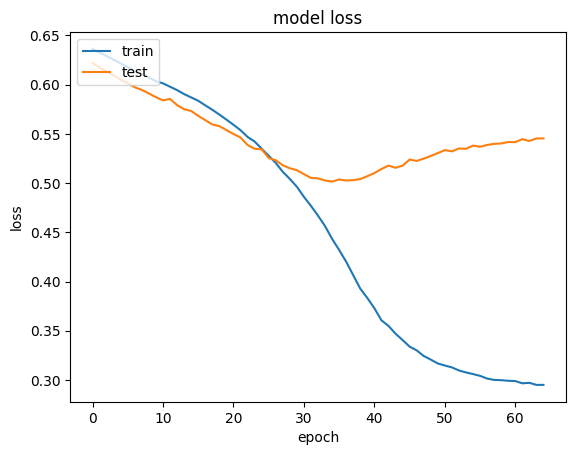

In [27]:
plt.plot(history.history["loss"][5:])
plt.plot(history.history["val_loss"][5:])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "test"], loc="upper left")
plt.show()

In [28]:
def recommender_system(user_id, model, n_movies):

  print("")
  print("Movie seen by the User:")
  pprint(list(refined_dataset[refined_dataset['user_id'] == user_id]['movie_title']))
  print("")

  encoded_user_id = user_enc.transform([user_id])

  seen_movies = list(refined_dataset[refined_dataset['user_id'] == user_id]['movie'])
  print(len(seen_movies))
  unseen_movies = [i for i in range(min(refined_dataset['movie']), max(refined_dataset['movie'])+1) if i not in seen_movies]
  print(len(unseen_movies))
  model_input = [np.asarray(list(encoded_user_id)*len(unseen_movies)), np.asarray(unseen_movies)]
  predicted_ratings = model.predict(model_input)
  predicted_ratings = np.max(predicted_ratings, axis=1)
  sorted_index = np.argsort(predicted_ratings)[::-1]
  recommended_movies = item_enc.inverse_transform(sorted_index)
  print("---------------------------------------------------------------------------------")
  print("Top "+str(n_movies)+" Movie recommendations for the User "+str(user_id)+ " are:")
  pprint(list(recommended_movies[:n_movies]))

  # Tạo DataFrame từ danh sách tên phim và dự đoán ratings
  recommendations_df = pd.DataFrame({
      'Tên Phim': recommended_movies[:n_movies],
      'Rating Dự Đoán': predicted_ratings[sorted_index][:n_movies]*(max_rating - min_rating)  + min_rating# Lấy các dự đoán tương ứng
  })

  return recommendations_df

In [29]:
# Test
df[df['user_id'] == "ur2467618"]['movie_id'].value_counts()

movie_id
tt0004972    1
tt0052225    1
tt0053114    1
tt0053072    1
tt0052997    1
            ..
tt0039661    1
tt0039628    1
tt0039501    1
tt0039286    1
tt0062512    1
Name: count, Length: 497, dtype: int64

In [ ]:
print("Enter user id")
user_id= input()

print("Enter number of movies to be recommended:")
n_movies = int(input())
rating_df = recommender_system(user_id,model,n_movies)
rating_df

## *Save model and load model to use*

In [32]:
model.save('Recommend_System')

INFO:tensorflow:Assets written to: Recommend_System\assets


INFO:tensorflow:Assets written to: Recommend_System\assets


In [33]:
loaded_model = tf.keras.models.load_model('Recommend_System')

In [34]:
print("Enter user id")
user_id= input()

print("Enter number of movies to be recommended:")
n_movies = int(input())
rating_df = recommender_system(user_id,loaded_model, n_movies)
rating_df

Enter user id
Enter number of movies to be recommended:

Movie seen by the User:
['12 Angry Men',
 '3 Godfathers',
 '8½',
 'A Bell for Adano',
 'A Cry in the Night',
 'A Night at the Opera',
 'A Star Is Born',
 'A Streetcar Named Desire',
 'A Yank in the R.A.F.',
 'Ace in the Hole',
 'Alexis Zorbas',
 'Alfie',
 'Alphaville: Une étrange aventure de Lemmy Caution',
 'Anatomy of a Murder',
 'Angel Face',
 'Animal Crackers',
 'Arsenic and Old Lace',
 'Artists and Models',
 'Ascenseur pour l&apos;échafaud',
 'Auntie Mame',
 'Banshun',
 'Battle Beneath the Earth',
 'Battle of the Bulge',
 'Battle of the Coral Sea',
 'Beat the Devil',
 'Beau James',
 'Becket',
 'Belle de jour',
 'Ben-Hur',
 'Berserk',
 'Between Two Worlds',
 'Bingo Crosbyana',
 'Bonnie and Clyde',
 'Born Yesterday',
 'Brief Encounter',
 'Bringing Up Baby',
 'Bronenosets Potemkin',
 'Bud Abbott and Lou Costello Meet Frankenstein',
 'Camelot',
 'Captain Clegg',
 'Carnival of Souls',
 'Casablanca',
 'Chain Lightning',
 'Charade'

,Tên Phim,Rating Dự Đoán
0,Alfie,9.925731
1,Auntie Mame,9.893542
2,Camelot,9.870921
3,Brief Encounter,9.861587
4,Animal Crackers,9.859078
5,Alexis Zorbas,9.856615
6,Berserk,9.854775
7,City Lights,9.831305
8,Becket,9.811176
9,Campanadas a medianoche,9.787570
